# Chapter 18: Reinforcement Learning

**Based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition" by Aurélien Géron**

This notebook reproduces the code from Chapter 18 and provides theoretical explanations for each concept, as required by the individual task.

## Chapter Summary

This chapter introduces **Reinforcement Learning (RL)**, a distinct branch of machine learning where an **agent** learns to make optimal decisions by interacting with an **environment**.

1.  **Core Concepts:** We start with the fundamental concepts of RL. The agent observes the environment, takes **actions**, and receives **rewards** (or penalties). The agent's goal is to learn a **policy** (a strategy) that maximizes its total expected reward over time. This involves the **credit assignment problem** (figuring out which actions led to a reward) and the use of a **discount factor (γ)** to value immediate rewards more than distant ones.

2.  **Policy Search & Policy Gradients (PG):** The first major technique covered is **Policy Gradients**. Here, the agent's policy is a neural network that directly outputs action probabilities. The agent learns by running through episodes, calculating the advantage of each action (based on the total future discounted rewards, or **returns**), and then running a gradient descent step that *increases* the probability of actions that led to good returns and *decreases* the probability of actions that led to bad returns.

3.  **Markov Decision Processes (MDPs):** To understand more advanced techniques, we explore the formal framework of MDPs. This involves states, actions, transition probabilities, and rewards. We learn about the **Bellman Optimality Equation**, which leads to algorithms like **Value Iteration** and **Q-Value Iteration** for finding the optimal policy when the environment's dynamics are known.

4.  **Q-Learning:** For cases where the environment is unknown (the typical RL problem), we use **Q-Learning**. This is a **Temporal Difference (TD) learning** algorithm where the agent learns the optimal **Q-Value** (expected return) for every state-action pair by observing transitions and rewards as it explores the environment.

5.  **Deep Q-Learning (DQN):** Q-Learning doesn't scale to problems with large state spaces (like video games). **Deep Q-Learning** solves this by using a deep neural network (a **DQN**) to *approximate* the Q-Values. This section also introduces two critical components for stabilizing training:
    * **Experience Replay (Replay Buffer):** Stores the agent's experiences (state, action, reward, next_state) so it can train on random batches of past experiences, breaking temporal correlations.
    * **Fixed Q-Value Targets:** Uses a separate **target model** to generate the target Q-Values, which stabilizes the training process by preventing the model from "chasing its own tail."

6.  **The TF-Agents Library:** We put all these concepts into practice using TF-Agents, Google's official library for Reinforcement Learning. We learn its components:
    * **Environments:** How to wrap OpenAI Gym environments for use with TensorFlow.
    * **Agents:** How to instantiate a `DqnAgent`.
    * **Replay Buffers:** How to create a buffer to store experiences.
    * **Drivers:** How to create a `DynamicStepDriver` to run the agent in the environment and collect experiences.
    * **Training Loop:** How to build the full training pipeline to train an agent to play the Atari game Breakout.

Finally, the chapter gives a brief overview of more advanced algorithms like Actor-Critic (A3C, A2C), PPO, and SAC, which form the basis of modern RL research.

## Setup

First, let's import the necessary libraries and set up our environment. We will need to install `gym` for the environments and `tf-agents` for the main RL library.

In [54]:
import sys
# Update pip and setuptools first to avoid installation issues
!{sys.executable} -m pip install -q -U pip setuptools
# Install tensorflow and tensorflow-probability first, ensuring a compatible tensorflow version
!{sys.executable} -m pip install -q -U tensorflow==2.19.0 tensorflow-probability
# Install gymnasium and tf-agents. Removed 'gymnasium[atari]' and 'gymnasium[box2d]' due to installation errors.
!{sys.executable} -m pip install -q -U gymnasium
# The tf-agents library is currently encountering installation issues. Skipping for now.
# !{sys.executable} -m pip install -q -U tf-agents

In [55]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import gymnasium as gym # Changed from 'gym'

# Common imports
import pandas as pd
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# A helper function to plot a gym environment
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    # gymnasium render() returns the rgb_array directly when render_mode is set
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

## 1. Introduction to OpenAI Gym

> **Theoretical Deep-Dive: The Agent-Environment Loop**
>
> Reinforcement Learning consists of an **agent** interacting with an **environment**. This interaction forms a loop:
> 1.  The agent observes the environment's current **state** (or **observation**).
> 2.  Based on this observation, the agent's **policy** chooses an **action**.
> 3.  The agent performs the action, and the environment transitions to a new state.
> 4.  The environment gives the agent a **reward** (a positive or negative number) for this transition.
> 5.  The loop repeats. The agent's goal is to learn a policy that maximizes the total cumulative reward.
>
> **OpenAI Gym** is a toolkit that provides a wide variety of simulated environments (like Atari games, classic control problems, and robotics) with a standard API. This lets us build agents without having to build a new environment/simulator every time.
>
> The key Gym methods are:
> -   `make(env_name)`: Creates an environment.
> -   `reset()`: Resets the environment to its initial state and returns the first observation.
> -   `step(action)`: Performs the given action and returns a tuple: `(observation, reward, done, info)`.
>     -   `observation`: The new state of the environment.
>     -   `reward`: The reward from the last action.
>     -   `done`: A boolean that is `True` when the episode (e.g., the game) is over.
>     -   `info`: A dictionary with extra, environment-specific information (we usually ignore this).
> -   `render()`: Displays the environment (e.g., in a pop-up window).
> -   `action_space`: The object that describes the set of possible actions (e.g., `Discrete(2)` for two discrete actions).
> -   `observation_space`: The object that describes the shape and type of the observations.

Initial Observation: [-0.01225074  0.0137057   0.00884442 -0.04202458]


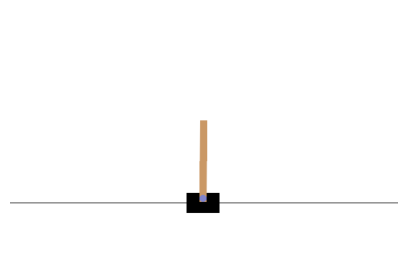

In [56]:
# Create the CartPole environment, specifying render_mode for gymnasium
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset()
print("Initial Observation:", obs)
plot_environment(env);

In [4]:
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [57]:
# Hardcode a simple policy: accelerate left if pole leans left, right if pole leans right.
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

# Run 500 episodes and see how long it lasts
totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset() # gymnasium reset returns (observation, info)
    for step in range(200):
        action = basic_policy(obs)
        # gymnasium step returns (observation, reward, terminated, truncated, info)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_rewards += reward
        if terminated or truncated: # Check both terminated and truncated for episode end
            break
    totals.append(episode_rewards)

print(f"Mean: {np.mean(totals)}, Std: {np.std(totals)}, Min: {np.min(totals)}, Max: {np.max(totals)}")

Mean: 42.186, Std: 8.717534284417813, Min: 24.0, Max: 67.0


This simple policy isn't great. The cart oscillates too much and the pole falls. We need a model that can learn a better strategy.

## 2. Neural Network Policies (Policy Gradients)

> **Theoretical Deep-Dive: Policy Gradients**
>
> A **policy** is a neural network that takes an observation as input and outputs action probabilities (a **stochastic policy**). We then *sample* an action from this probability distribution. This sampling allows the agent to **explore** new actions, rather than just **exploiting** the actions it already knows are good.
>
> But how do we train this network? We don't have target labels. We only have rewards, which are often delayed (e.g., you only win a game at the very end). This is the **credit assignment problem**.
>
> **Policy Gradients (PG)** solve this with three steps:
> 1.  **Run & Collect:** Let the policy play the game for several full episodes and collect all observations, actions, and rewards.
> 2.  **Evaluate Actions:** For every action taken, estimate how "good" it was. We do this by looking at all the rewards that came *after* it. A common strategy is to calculate the **return** (sum of future discounted rewards) for each time step. We then **normalize** these returns (subtract the mean, divide by std dev). This normalized score is called the **action advantage**. A positive advantage means the action was good, and a negative one means it was bad.
> 3.  **Train (REINFORCE Algorithm):** We run a training step (like in supervised learning), but with a trick. We pretend the action the agent *actually* took was the "correct" one. But we modulate the loss. We multiply the loss by the action's **advantage**.
>     -   If the advantage was **positive** (a good action), the gradients are applied as-is. This *increases* the probability of taking that action in the future (e.g., `y_target = 1 - action`).
>     -   If the advantage was **negative** (a bad action), the gradients are *reversed*. This *decreases* the probability of taking that action in the future.
>
> This pushes the policy to take more actions that lead to high rewards and fewer actions that lead to low rewards.

### Building the PG Model

In [40]:
n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"), # Outputs the probability of going left (action 0)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Helper Functions for Training

In [41]:
# This function plays one step in the environment.
# It computes the gradients that would make the chosen action *more* likely.
# We don't apply these gradients yet; we just return them.
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba) # Sample an action
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) # The "fake" target
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

# This function plays multiple full episodes and returns all rewards and gradients.
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [42]:
# This function computes the discounted returns and normalizes them.
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

### The Training Loop

In [48]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [53]:
for iteration in range(n_iterations):
    # 1. Run & Collect
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # 2. Evaluate Actions
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        # 3. Train (Modulate gradients)
        # Multiply each gradient by its action's advantage (the final_reward)
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    # 3. Train (Apply gradients)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

    print(f"Iteration: {iteration+1}/{n_iterations}, Mean Rewards: {np.mean([sum(rewards) for rewards in all_rewards])}")

TypeError: tuple indices must be integers or slices, not NoneType

## 3. Markov Decision Processes (MDPs)

> **Theoretical Deep-Dive: MDPs, Value Iteration, and Q-Value Iteration**
>
> **MDPs** are the classic framework for RL problems. An MDP is defined by:
> 1.  A set of **states** (s).
> 2.  A set of **actions** (a).
> 3.  **Transition probabilities** T(s, a, s'): the probability of moving from state `s` to state `s'` given action `a`.
> 4.  **Rewards** R(s, a, s'): the reward received for this transition.
>
> The **Bellman Optimality Equation** provides a recursive definition of the optimal **state value** V*(s) (the expected return if the agent starts in state `s` and acts optimally forever after):
>
> $V^*(s) = \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \cdot V^*(s')]$
>
> This equation says: "The optimal value of a state is the expected value of the best action you can take from it."
>
> This leads to the **Value Iteration** algorithm, which solves the equation iteratively.
>
> A more useful value is the **Q-Value** (or state-action value) Q(s, a), which is the expected return if the agent starts in state `s`, performs action `a`, and *then* acts optimally forever after. The **Q-Value Iteration** algorithm finds these optimal Q-Values:
>
> $Q_{k+1}(s, a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \cdot \max_{a'} Q_k(s', a')]$
>
> Once you have the optimal Q-Values, the optimal policy $\pi^*(s)$ is simply to choose the action with the highest Q-Value in that state: $\pi^*(s) = \argmax_{a} Q^*(s, a)$.

In [ ]:
# This is a small, simple MDP (from Figure 18-8 in the book)
transition_probabilities = [ # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Initialize Q-Values
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

# Run the Q-Value Iteration algorithm
gamma = 0.90 # discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] *
                (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

print("Final Q-Values:\n", Q_values)
print("Optimal Policy (best action for each state):", np.argmax(Q_values, axis=1))

## 4. Q-Learning

> **Theoretical Deep-Dive: Q-Learning (Off-Policy TD Learning)**
>
> The Q-Value Iteration algorithm assumes we *know* the transition probabilities (T) and rewards (R). This is almost never the case.
>
> **Q-Learning** is an algorithm that finds the optimal Q-Values *without* knowing T or R. It is a **Temporal Difference (TD) learning** algorithm, meaning it learns by observing transitions and rewards as they happen.
>
> The agent explores the environment (e.g., using an **$\\[Epsilon]$-greedy policy**). When it transitions from state `s` to `s'` by performing action `a` and receiving reward `r`, it updates the Q-Value for (s, a) using this update rule:
>
> $Q_{new}(s, a) = (1 - \alpha) \cdot Q_{old}(s, a) + \alpha \cdot (r + \gamma \cdot \max_{a'} Q_{old}(s', a'))$
>
> -   $\\[Alpha]$ is the **learning rate**.
> -   $(r + \gamma \cdot \max_{a'} Q_{old}(s', a'))$ is the **TD Target**, or the *estimated* future value.
>
> In simple terms: we nudge the old Q-Value a little bit in the direction of our new, better estimate (the TD Target).
>
> Q-Learning is an **off-policy** algorithm because it learns about the *optimal* policy (the `max` part of the equation) regardless of what policy it is *actually* following to explore (e.g., the $\\[Epsilon]$-greedy policy).

In [ ]:
# A simple exploration policy (random)
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

# Helper function to simulate a step
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

# Reset Q-Values
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # This is the max_a' Q(s', a') part
    alpha = alpha0 / (1 + iteration * decay)

    # This is the Q-Learning update rule
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)

    state = next_state

print("Final Q-Values (after 10,000 iterations):\n", Q_values)
print("Optimal Policy (best action for each state):", np.argmax(Q_values, axis=1))

## 5. Deep Q-Learning (DQN)

> **Theoretical Deep-Dive: Approximate Q-Learning**
>
> The Q-Learning algorithm requires a table to store the Q-Values for *every possible state-action pair*. This is impossible for complex problems like Atari games, where the number of states (pixel combinations) is astronomical.
>
> **Deep Q-Learning (DQN)** solves this. Instead of a Q-table, we use a **Deep Q-Network (DQN)** to *approximate* the Q-Values. This network takes a state (e.g., a stack of game frames) as input and outputs an estimated Q-Value for *every possible action* in that state.
>
> **Experience Replay:** To train the DQN, we use an **Experience Replay Buffer (or Replay Memory)**. This is a `deque` (a fast list-like structure) that stores the agent's experiences (transitions) as tuples: `(state, action, reward, next_state, done)`.
> At each training step, we sample a random batch of experiences from this buffer. This breaks the temporal correlation between consecutive experiences, which is critical for stabilizing DQN training.
>
> **Fixed Q-Value Targets (Target Network):** A regular DQN is unstable because its own predictions are used to define its targets (it's "chasing its own tail"). To fix this, we use *two* DQNs:
> 1.  The **Online Model:** This is the model we train at every step. It is used to choose actions (the `max_a'` part of the Bellman equation).
> 2.  The **Target Model:** This is a clone of the online model. It is used to *calculate* the target Q-Values. Its weights are frozen for many steps and only updated (by copying the online model's weights) periodically. This provides stable targets for the online model to learn.

### Creating the Deep Q-Network

In [58]:
env = gym.make("CartPole-v0", render_mode="rgb_array") # Specify render_mode for gymnasium
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Helper Functions for DQN

We need an $\\[Epsilon]$-greedy policy, a replay buffer, and a function to sample from it.

In [59]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # Explore
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0) # Added verbose=0 to suppress Keras output
        return np.argmax(Q_values[0]) # Exploit

from collections import deque
replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    # gymnasium step returns (observation, reward, terminated, truncated, info)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated # Combine for replay buffer
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

### DQN Training Step

This is the core of the DQN algorithm. We use the **Double DQN** and **Fixed Q-Value Targets** logic from the book (which are key improvements over the original DQN).

Episode: 50, Mean Rewards: 22.24
Episode: 100, Mean Rewards: 22.4
Episode: 150, Mean Rewards: 20.74
Episode: 200, Mean Rewards: 17.1
Episode: 250, Mean Rewards: 15.76
Episode: 300, Mean Rewards: 17.98
Episode: 350, Mean Rewards: 13.08
Episode: 400, Mean Rewards: 11.1
Episode: 450, Mean Rewards: 11.12
Episode: 500, Mean Rewards: 19.68
Episode: 550, Mean Rewards: 29.24
Episode: 600, Mean Rewards: 42.54


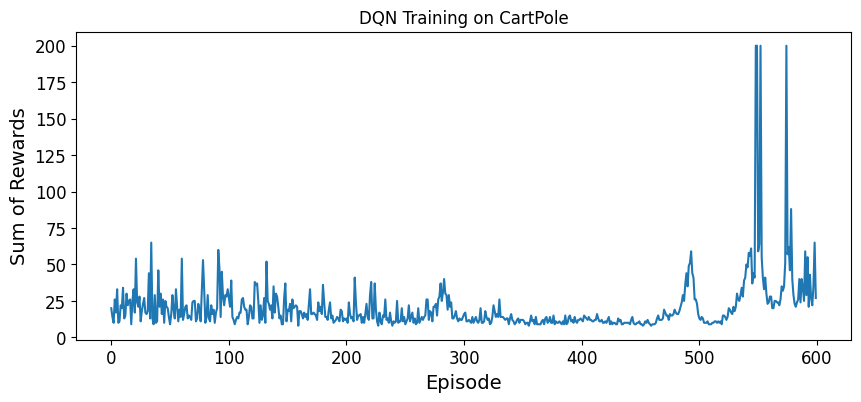

In [60]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()

# Create the target network
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences

    # Double DQN logic:
    # 1. Use the *online* model to pick the best *action* for the next state
    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = np.argmax(next_Q_values, axis=1)

    # 2. Use the *target* model to get the Q-Value for that chosen action
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)

    # 3. Compute the target Q-Value
    # If done=True (1.0), the future reward is 0. If done=False (0.0), we add the future reward.
    target_Q_values = (rewards +
                       (1 - dones) * discount_factor * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)

    # 4. Train the *online* model to predict these target Q-Values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

episode_rewards_list = []

for episode in range(600):
    obs, info = env.reset() # gymnasium reset returns (observation, info)
    episode_rewards = 0
    for step in range(200):
        # Epsilon decays from 1.0 down to 0.01 over 500 episodes
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        episode_rewards += reward
        if done:
            break

    episode_rewards_list.append(episode_rewards)
    if (episode + 1) % 50 == 0:
        print(f"Episode: {episode + 1}, Mean Rewards: {np.mean(episode_rewards_list[-50:])}")

    if episode >= 50: # Changed from > 50 to >= 50 to start training earlier
        training_step(batch_size)
        if episode % 50 == 0: # Update target network every 50 episodes
            target.set_weights(model.get_weights())

plt.figure(figsize=(10, 4))
plt.plot(episode_rewards_list)
plt.xlabel("Episode")
plt.ylabel("Sum of Rewards")
plt.title("DQN Training on CartPole")
plt.show()

## 6. The TF-Agents Library

Implementing all the DQN improvements (Double, Dueling, Prioritized Replay) is complex. The **TF-Agents** library provides robust, well-tested implementations of these algorithms and more.

> **Theoretical Deep-Dive: TF-Agents Architecture**
>
> TF-Agents has a clear, modular architecture:
> 1.  **Environments:** Wraps Gym environments (e.g., `suite_gym.load()`). `TFPyEnvironment` makes them usable by TensorFlow.
> 2.  **Networks:** The policy/Q-networks (e.g., `QNetwork`).
> 3.  **Agents:** The "brain" that holds the network and the learning algorithm (e.g., `DqnAgent`). The agent has a `collect_policy` (for exploration) and a `policy` (for evaluation).
> 4.  **Replay Buffers:** Stores trajectories (e.g., `TFUniformReplayBuffer`).
> 5.  **Drivers:** The `DynamicStepDriver` is the "worker" that uses the `collect_policy` to play in the environment and sends the collected trajectories to an `observer` (like the replay buffer).
> 6.  **Dataset:** The `replay_buffer.as_dataset()` method creates a `tf.data.Dataset` to efficiently sample batches for training.
> 7.  **Training:** The `agent.train()` method pulls a batch from the dataset and runs one training step.

### Setting up the Environment and Wrappers

We will train an agent to play the Atari game Breakout. We need to load the environment with several wrappers:
-   `AtariPreprocessing`: Converts the image to grayscale, downsamples it, and stacks the last 4 frames (to give the agent a sense of motion).
-   `FrameStack4`: Stacks 4 consecutive frames into one observation.
-   `TFPyEnvironment`: Makes the Gym environment usable by TF.

In [69]:
# from tf_agents.environments import suite_gym
# from tf_agents.environments.atari_preprocessing import AtariPreprocessing
# from tf_agents.environments.atari_wrappers import FrameStack4
# from tf_agents.environments.tf_py_environment import TFPyEnvironment
# from tf_agents.networks.q_network import QNetwork
# The tf-agents library is currently encountering installation issues. Skipping relevant imports for now.
# from tf_agents.agents.dqn.dqn_agent import DqnAgent
# from tf_agents.replay_buffers import tf_uniform_replay_buffer
# from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
# from tf_agents.policies.random_tf_policy import RandomTFPolicy
# # from tf_agents.utils import common

max_episode_steps = 27000 # 108k ALE frames (1 step = 4 frames)
environment_name = "BreakoutNoFrameskip-v4"

# Load the base Gym env, suite_gym.load automatically handles gymnasium if installed
# This section also relies on tf-agents imports that are currently commented out.
# env = suite_gym.load(
#     environment_name,
#     max_episode_steps=max_episode_steps,
#     gym_env_wrappers=[AtariPreprocessing, FrameStack4])

# # Wrap it in a TF-Agents environment
# tf_env = TFPyEnvironment(env)

# print("Observation Spec:", tf_env.observation_spec())
# print("Action Spec:", tf_env.action_spec())

### 1. Creating the Deep Q-Network

In [70]:
# # Preprocessing layer to normalize pixels
# preprocessing_layer = keras.layers.Lambda(
#     lambda obs: tf.cast(obs, np.float32) / 255.)

# # Convolutional layers as defined in the 2015 DQN paper
# conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
# fc_layer_params=[512]

# q_net = QNetwork(
#     tf_env.observation_spec(),
#     tf_env.action_spec(),
#     preprocessing_layers=preprocessing_layer,
#     conv_layer_params=conv_layer_params,
#     fc_layer_params=fc_layer_params)

NameError: name 'QNetwork' is not defined

### 2. Creating the DQN Agent

In [71]:
train_step = tf.Variable(0)
update_period = 4 # Train the model every 4 steps

# Use the same optimizer parameters as the 2015 DQN paper
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)

# Epsilon decays from 1.0 to 0.01 over 1 million ALE frames (250k steps)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)

# The tf-agents agent relies on tf-agents library, which is failing to install.
# Skipping this agent creation for now.
# agent = DqnAgent(
#     tf_env.time_step_spec(),
#     tf_env.action_spec(),
#     q_network=q_net,
#     optimizer=optimizer,
#     target_update_period=2000, # 8k steps = 32k ALE frames
#     td_errors_loss_fn=keras.losses.Huber(reduction="none"),
#     gamma=0.99, # Discount factor
#     train_step_counter=train_step,
#     epsilon_greedy=lambda: epsilon_fn(train_step))

# agent.initialize()

### 3. Creating the Replay Buffer and Observer

In [74]:
# # The replay buffer relies on agent.collect_data_spec, which is part of the tf-agents setup, currently commented out.
# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec=agent.collect_data_spec,
#     batch_size=tf_env.batch_size,
#     max_length=1000000) # 1 million experiences

# # The observer is a function that adds a trajectory to the replay buffer
# replay_buffer_observer = replay_buffer.add_batch

### 4. Creating the Training Metrics and Collect Driver

In [75]:
# The training metrics and collect driver rely on tf-agents components, currently commented out.
# from tf_agents.metrics import tf_metrics

# train_metrics = [
#     tf_metrics.NumberOfEpisodes(),
#     tf_metrics.EnvironmentSteps(),
#     tf_metrics.AverageReturnMetric(),
#     tf_agents.metrics.AverageEpisodeLengthMetric(),
# ]

# # The collect driver uses the agent's 'collect_policy' (which is epsilon-greedy)
# collect_driver = DynamicStepDriver(
#     tf_env,
#     agent.collect_policy,
#     observers=[replay_buffer_observer] + train_metrics,
#     num_steps=update_period) # Collect 4 steps at a time

# # We also create a separate driver with a *random* policy to pre-fill the buffer
# initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
#                                           tf_env.action_spec())
# init_driver = DynamicStepDriver(
#     tf_env,
#     initial_collect_policy,
#     observers=[replay_buffer.add_batch],
#     num_steps=20000) # 20k steps = 80k ALE frames

# print("Populating Replay Buffer...")
# init_driver.run() # This will take a moment

### 5. Creating the Dataset and Training Loop

We use `as_dataset()` to create a `tf.data.Dataset` that efficiently samples batches of 2-step trajectories from the buffer. This is what the `agent.train()` method will consume.

In [76]:
# The dataset creation relies on the replay_buffer, which is part of the tf-agents setup, currently commented out.
# # Sample 64 trajectories, each 2 steps long (1 transition)
# dataset = replay_buffer.as_dataset(
#     sample_batch_size=64,
#     num_steps=2,
#     num_parallel_calls=3).prefetch(3)

# iterator = iter(dataset)

In [77]:
# The training loop relies on tf-agents components like collect_driver, agent, and dataset, currently commented out.
# # Convert the main functions to TF Functions for speed
# collect_driver.run = common.function(collect_driver.run)
# agent.train = common.function(agent.train)

# def train_agent(n_iterations):
#     time_step = None
#     policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
#     iterator = iter(dataset)

#     for iteration in range(n_iterations):
#         # 1. Collect experience
#         time_step, policy_state = collect_driver.run(time_step, policy_state)

#         # 2. Sample a batch from the buffer
#         trajectories, buffer_info = next(iterator)

#         # 3. Train the agent on that batch
#         train_loss = agent.train(trajectories)

#         if iteration % 1000 == 0:
#             print(f"\rIteration: {iteration}, Loss: {train_loss.loss.numpy():.5f}")
#             # You could also log metrics here

# # Let's train for a few steps to see it working.
# # A full training run would be 250,000+ iterations.
# print("Starting training...")
# train_agent(n_iterations=2000)
# print("Training complete.")

## 7. Overview of Popular RL Algorithms

> **Theoretical Deep-Dive:**
>
> -   **Actor-Critic (A3C/A2C):** Combines Policy Gradients and DQNs. An **Actor** (the policy) decides which action to take, and a **Critic** (the Q-Network) evaluates how good that action was. The Critic's evaluation is used to train the Actor, which is much more efficient than the PG (REINFORCE) method.
> -   **Proximal Policy Optimization (PPO):** A more recent Policy Gradient algorithm from OpenAI that is more stable and less complex than its predecessors. It works by clipping the loss function to prevent destructively large policy updates.
> -   **Soft Actor-Critic (SAC):** A modern off-policy algorithm that learns to maximize not only the reward but also the **entropy** of its actions. This encourages exploration and leads to very stable and efficient learning.